In [36]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from collections import Counter
import scipy.optimize as so

In [57]:
# %% Read in data
full = Table.read('full.fits', format = 'fits')

In [70]:
# %% Make subset with only galaxies
galaxy = full[full['CLASS'] == 'GALAXY']

In [71]:
# Drop NaN elements (otherwise will return error when calculating colour)
galaxy_nonan = galaxy[~np.isnan(galaxy['FLUX_R'])]
print('Data points before:', len(galaxy))
print('Data points after dropping NaN', len(galaxy_nonan))

Data points before: 2541424
Data points after dropping NaN 2310132


In [73]:
# %% Make list of galaxy subclasses
print(Counter(galaxy_nonan['SUBCLASS']))
subclasses = np.unique(galaxy_nonan['SUBCLASS'])
print(len(subclasses))

Counter({' ': 1939152, 'STARFORMING': 251676, 'STARBURST': 75407, 'AGN': 23168, 'BROADLINE': 15590, 'AGN BROADLINE': 3528, 'STARFORMING BROADLINE': 1435, 'STARBURST BROADLINE': 176})
8


In [132]:
# %% Define functions to calculate g-r and r-z
def g_r(table):
    ''' Returns an Astropy table column of g-r colour, dropping rows with negative fluxes in either 'FLUX_G' or 'FLUX_R' 
    
    Input arguments:
    table: Astropy table, must have columns labelled 'FLUX_G', and 'FLUX_R'
    '''
    table_r = table[table['FLUX_R'] > 0.0]
    table_gr = table_r[table_r['FLUX_G'] > 0.0]
    return -2.5*np.log10(table_gr['FLUX_R']/table_gr['FLUX_G']), table_gr['Z']

def r_z(table):
    ''' Returns an Astropy table column of r-z colour, dropping rows with negative fluxes in either 'FLUX_R' or 'FLUX_Z'
    and an Astropy column of the corresponding redshift z.
    Input arguments:
    table: Astropy table, must have a a column labelled 'FLUX_R' and 'FLUX_Z'
    '''
    table_z = table[table['FLUX_Z'] > 0.0]
    table_rz = table_z[table_z['FLUX_R'] > 0.0]
    return -2.5*np.log10(table_rz['FLUX_Z']/table_rz['FLUX_R']), table_rz['Z']

In [109]:
# %% Check how many negative fluxes will be dropped
print('Data points before:', len(galaxy_nonan))
print('g-r data points after:', len(g_r(galaxy_nonan)[0]))
print('r-z data points after:', len(r_z(galaxy_nonan)[0]))

Data points before: 2310132
g-r data points after: 2236667
r-z data points after: 2235660


## Colour vs redshift

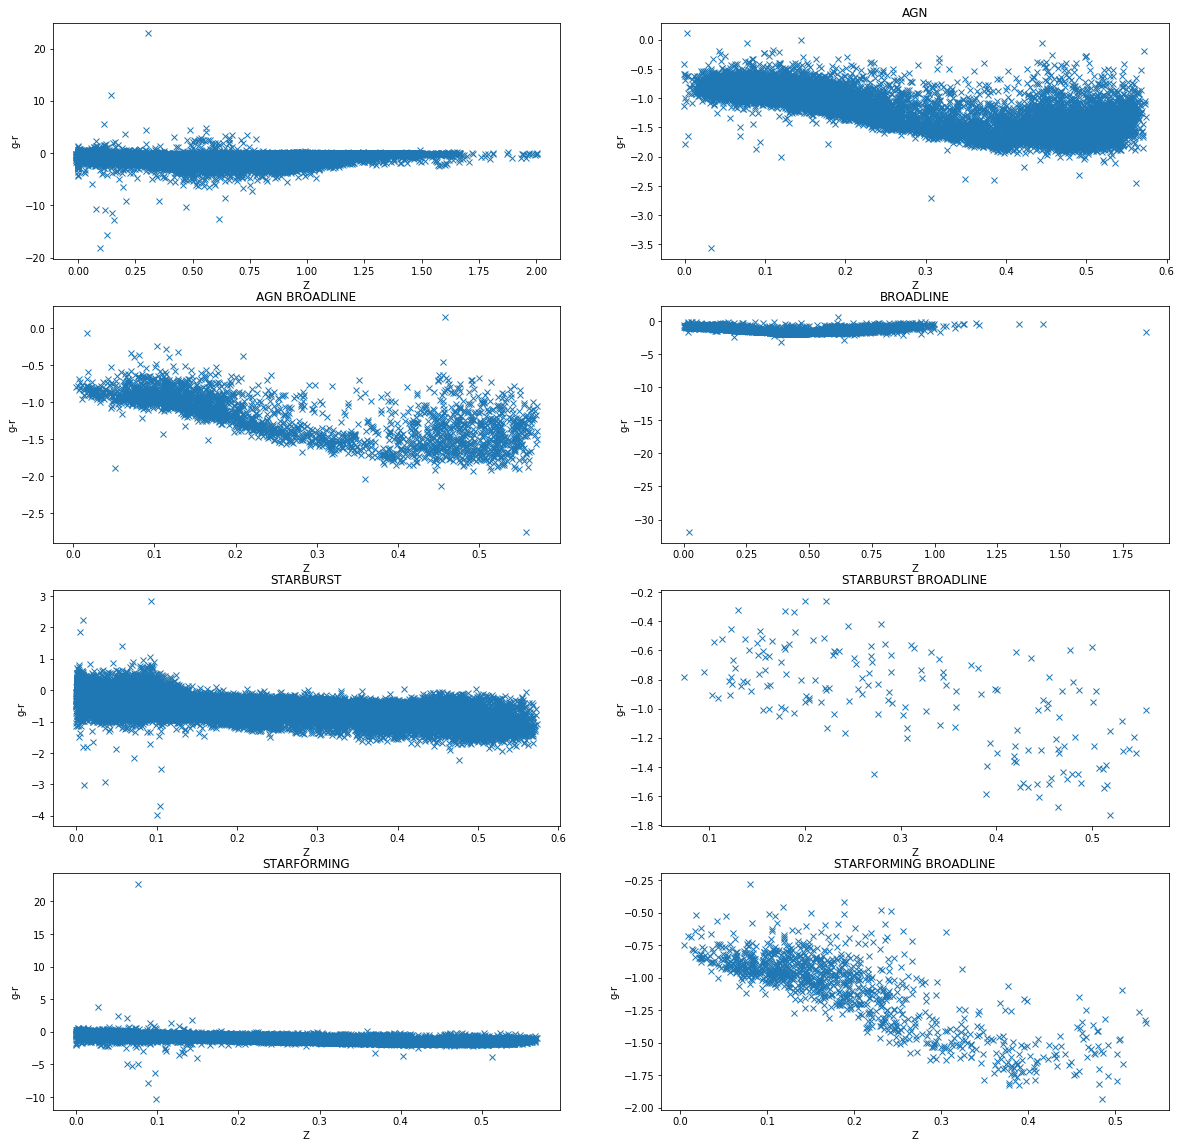

In [110]:
# %% Plot g-r scatter plots of colour against redshift for different subclasses
plt.figure(figsize=(20,20))
for i in range(len(subclasses)):
    plt.subplot(4,2,i+1)
    subclass_set = galaxy_nonan[galaxy_nonan['SUBCLASS'] == subclasses[i]]
    gr_colour, z = g_r(subclass_set)
    plt.plot(z, gr_colour, 'x')
    plt.title(f'{subclasses[i]}')
    plt.xlabel('Z')
    plt.ylabel('g-r')
plt.show()

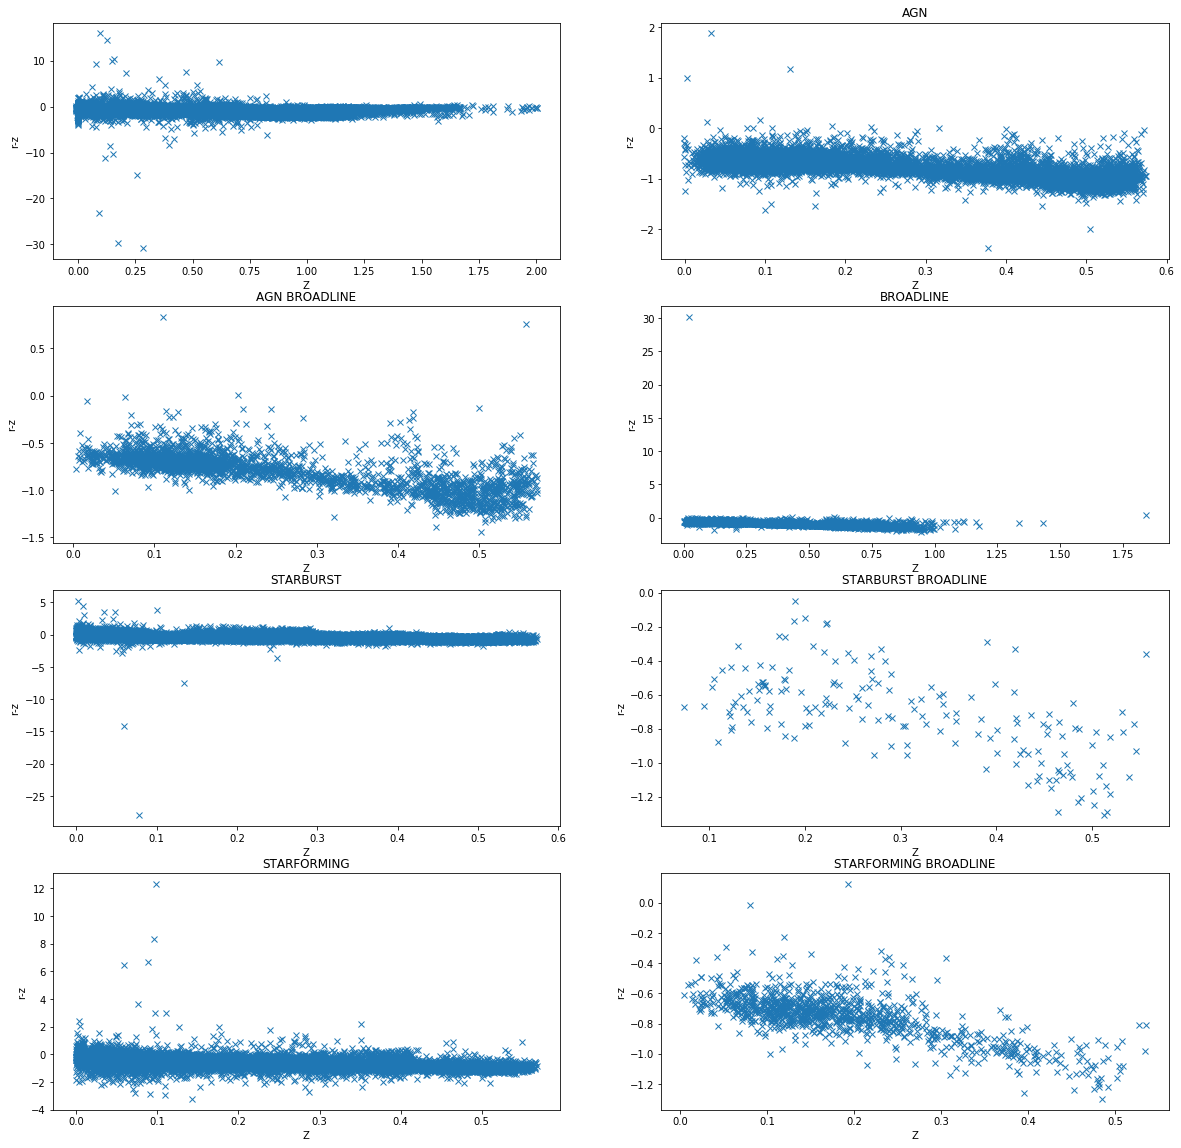

In [111]:
# %% Plot r-z scatter plots of colour against redshift for different subclasses
plt.figure(figsize=(20,20))
for i in range(len(subclasses)):
    plt.subplot(4,2,i+1)
    subclass_set = galaxy_nonan[galaxy_nonan['SUBCLASS'] == subclasses[i]]
    rz_colour, z = r_z(subclass_set)
    plt.plot(z, rz_colour, 'x')
    plt.title(f'{subclasses[i]}')
    plt.xlabel('Z')
    plt.ylabel('r-z')
plt.show()

Scatter plot too dense so use 2D density contour plot

In [127]:
# %% Define functions for plotting 2D density contour plot
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [three_sigma, two_sigma, one_sigma]
    print(levels)

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=sorted(levels))
        #plt.clabel(contour, inline = 1, fontsize = 15, fmt = '%.5e')
    else:
        contour = ax.contour(X, Y, Z, levels=sorted(levels))
        #ax.clabel(contour, inline = 1, fontsize = 15, fmt = '%.5e')
    return contour

def density_contour_w_hist(xdata, ydata, nbins_x, nbins_y, xlabel, ylabel):
    # code from https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html

    # Define axes positions
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_contour = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    plt.figure(figsize=(15, 10))
   
    # Make axes
    ax_contour = plt.axes(rect_contour)
    ax_contour.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    density_contour(xdata,ydata,nbins_x,nbins_y,ax=ax_contour)
    ax_histx.hist(xdata, bins = nbins_x)
    ax_histy.hist(ydata, bins = nbins_y, orientation='horizontal')
    ax_histx.set_xlim(ax_contour.get_xlim())
    ax_histy.set_ylim(ax_contour.get_ylim())
    ax_contour.set_xlabel(xlabel)
    ax_contour.set_ylabel(ylabel)

    plt.show()

[0.00021058118966185322, 0.0014056629801589243, 0.012219074185687134]


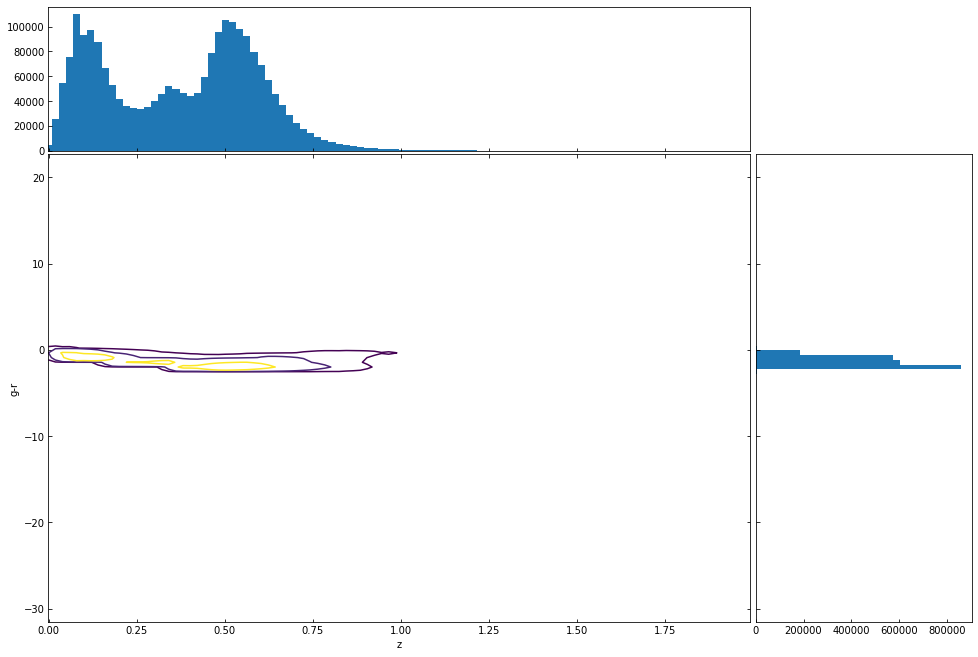

In [128]:
# Make g-r vs redshift 2D density contour plot for all galaxies
nbins_x = 100
nbins_y = 100
gr_all, z_gr_all = g_r(galaxy_nonan)
density_contour_w_hist(z_gr_all,gr_all,nbins_x,nbins_y,'z','g-r')

 
[0.00015769348419644415, 0.0009276398590452233, 0.013182751930892774]


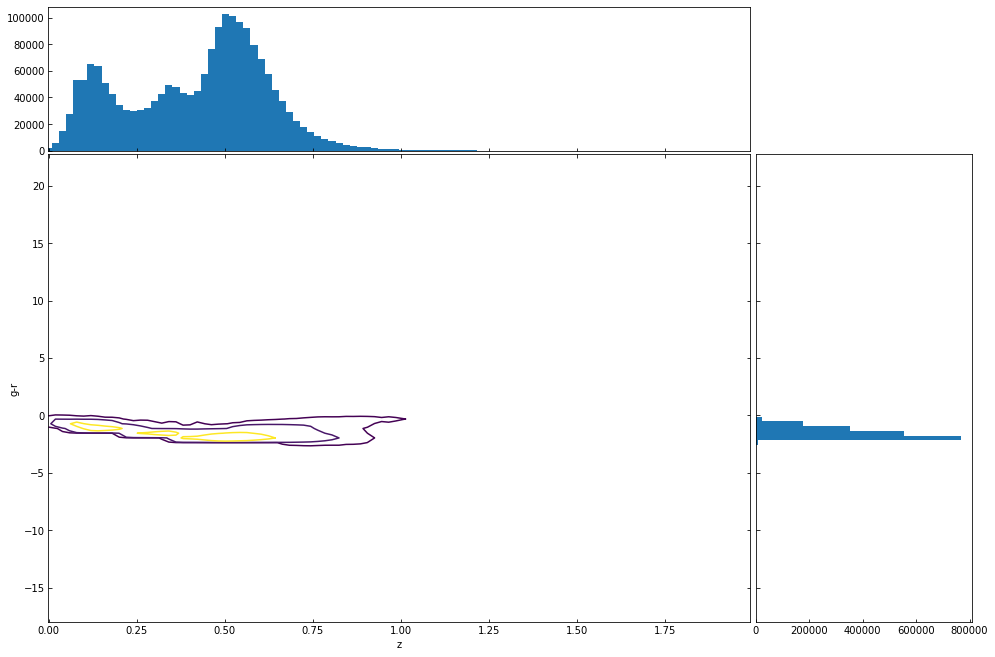

AGN
[5.059704467913046e-05, 0.00010119409143631434, 0.000556567496593103]


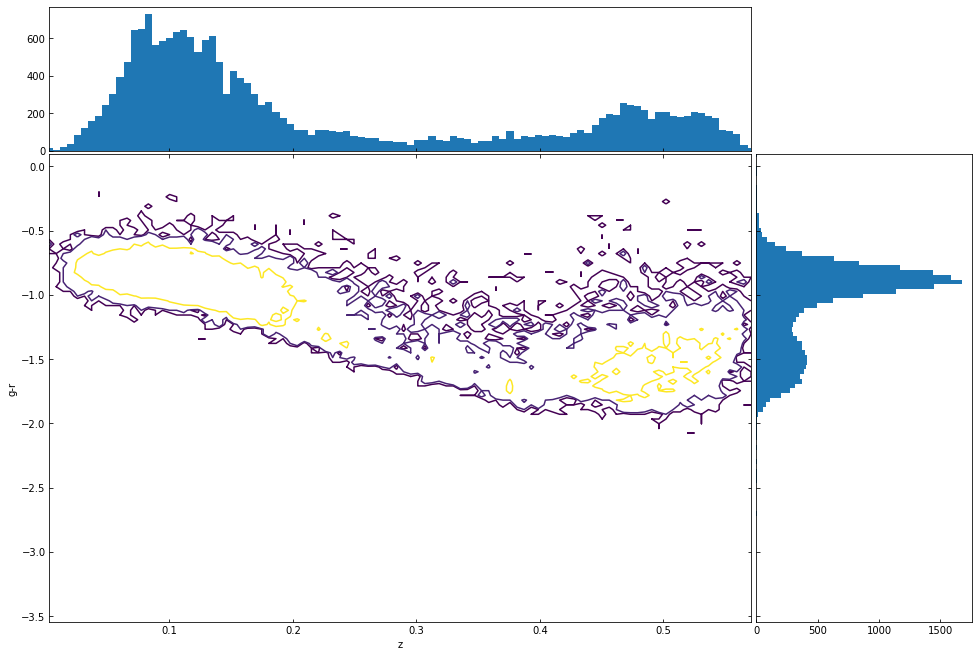

AGN BROADLINE
[0.0003652300947380035, 0.00036523009398697974, 0.0007304601897720689]


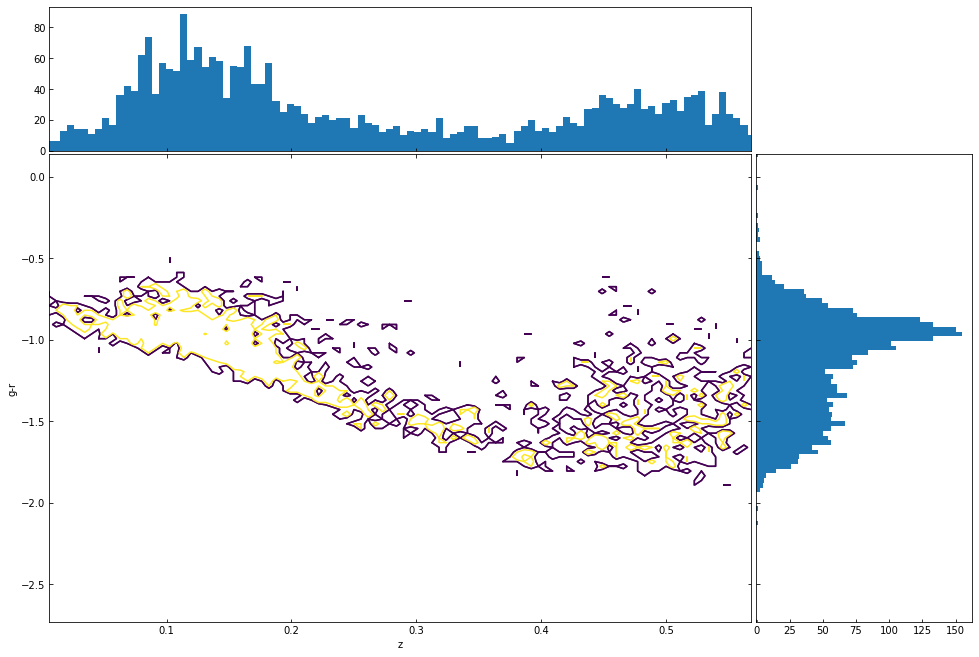

BROADLINE
[0.00018944776115203813, 0.0010419626786364762, 0.010419626786842199]


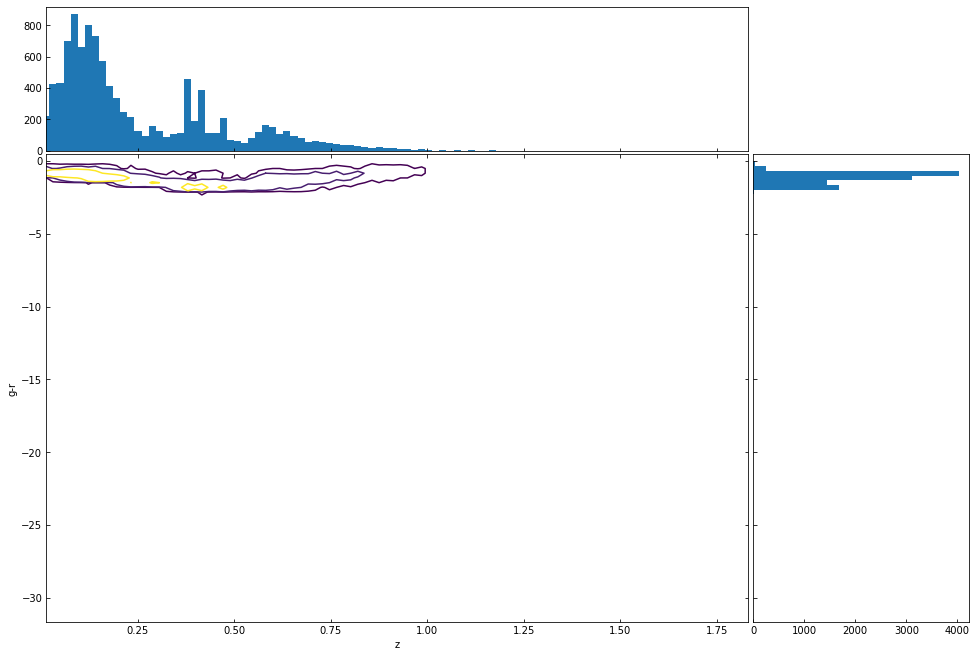

STARBURST
[4.073928129517412e-05, 0.00012221784647217202, 0.0009777427709836352]


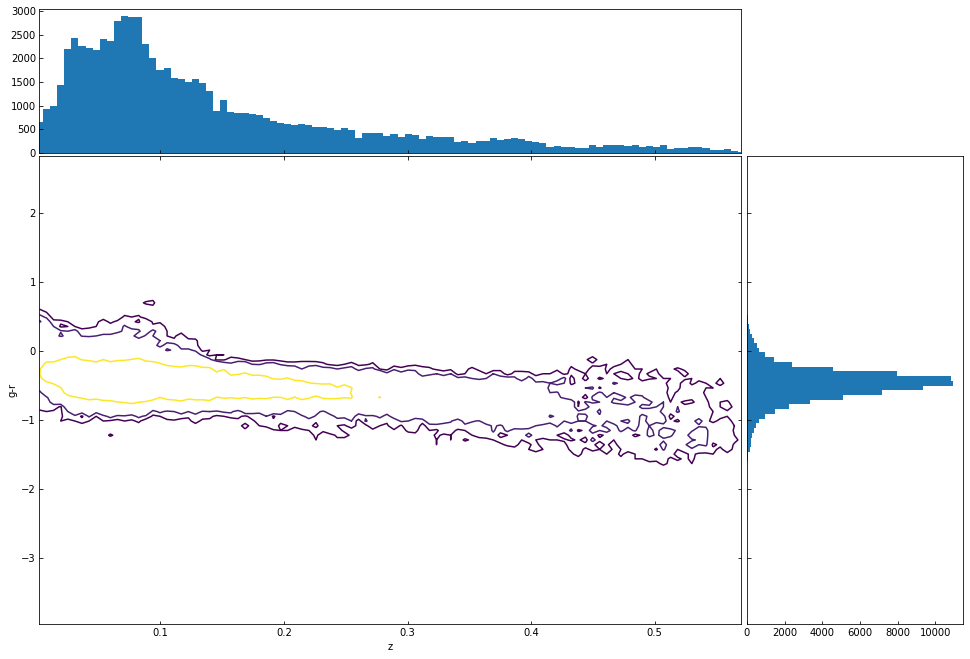

STARBURST BROADLINE
[0.005882352940335239, 0.005882352940680213, 0.0058823529397157934]


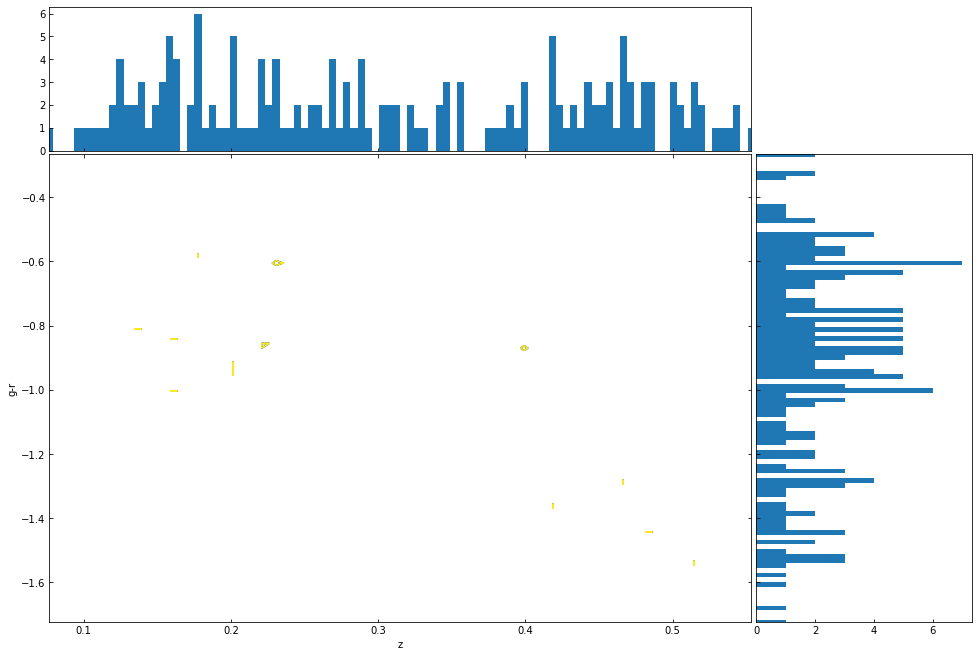

STARFORMING
[0.00014226655635390955, 0.0004770113984750065, 0.010201349020686165]


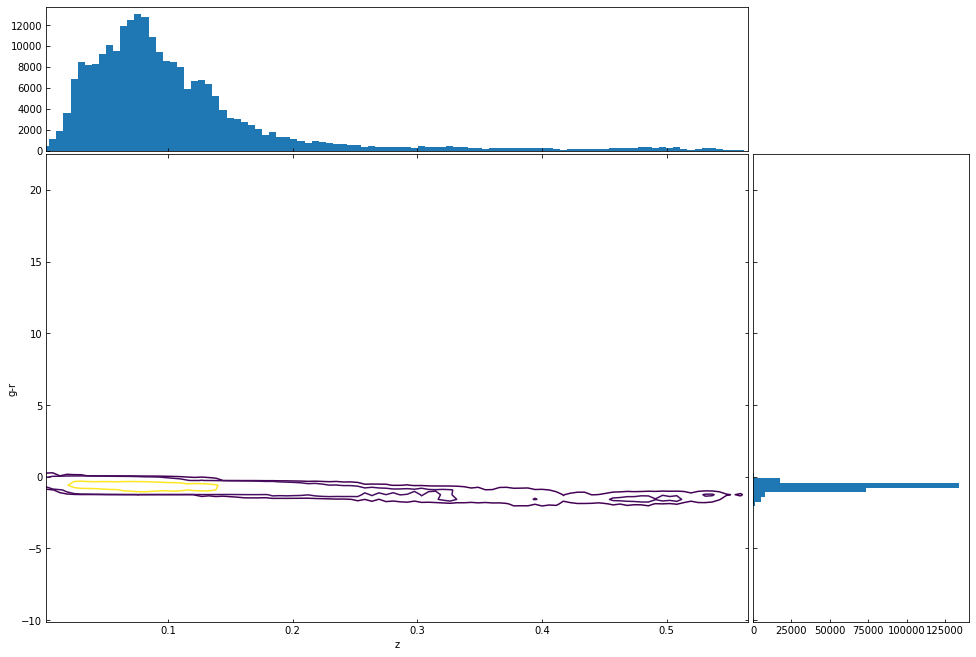

STARFORMING BROADLINE
[0.0009354536948130425, 0.0009354536946039178, 0.0009354536956901801]


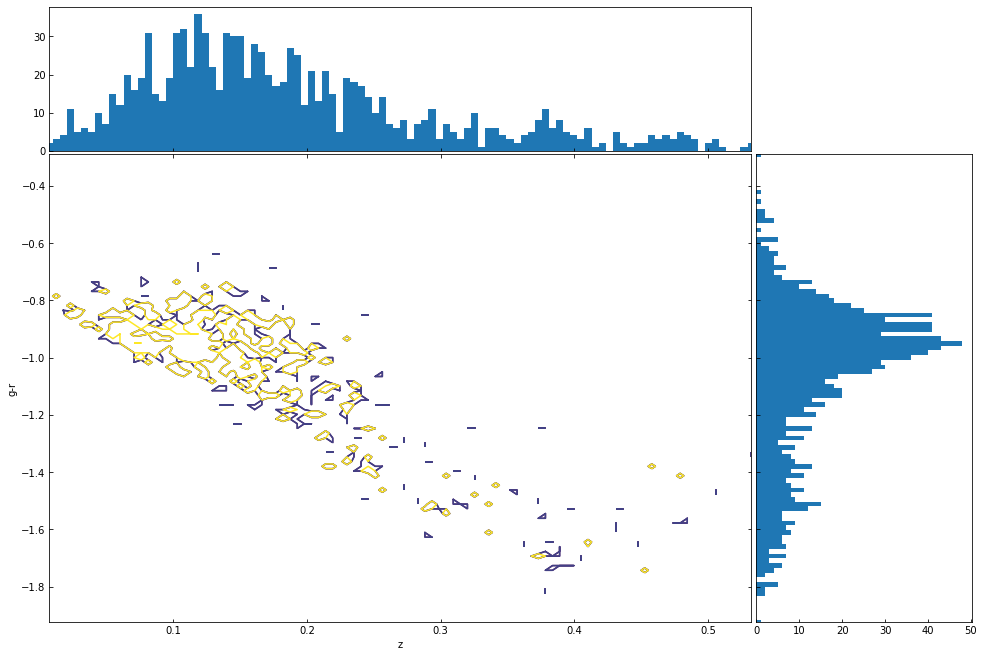

In [129]:
# %% Make g-r vs redshift 2D density contour plot for each galaxy subclass
for j in range(len(subclasses)):
    print(subclasses[j])
    subclass_set = galaxy_nonan[galaxy_nonan['SUBCLASS'] == subclasses[j]]
    gr_colour, z_gr = g_r(subclass_set)
    density_contour_w_hist(z_gr,gr_colour,nbins_x,nbins_y,'z','g-r')

[0.0002352772790053499, 0.0017806822146067965, 0.01633879927991843]


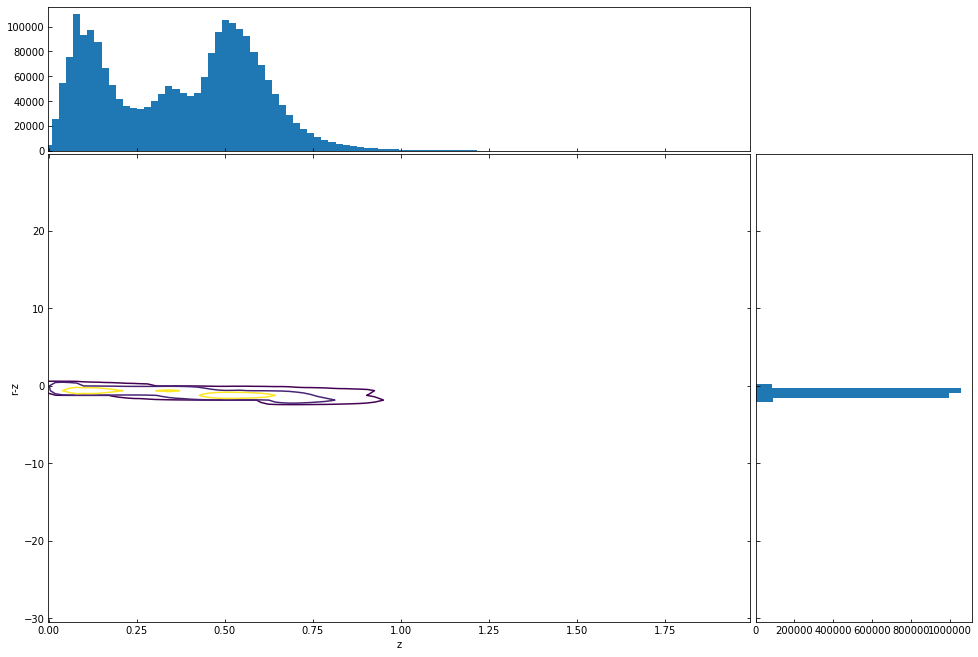

In [130]:
# Make r-z vs redshift 2D density contour plot for all galaxies
nbins_x = 100
nbins_y = 100
rz_all, z_rz_all = r_z(galaxy_nonan)
density_contour_w_hist(z_rz_all,rz_all,nbins_x,nbins_y,'z','r-z')

 
[0.0001974668130094129, 0.001198565321053327, 0.015241473325529614]


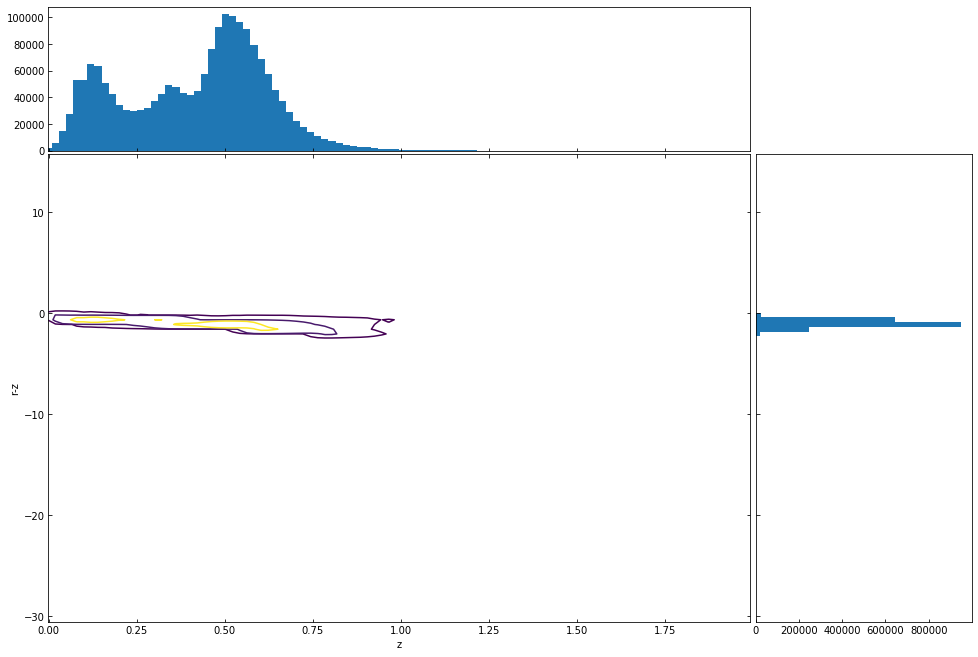

AGN
[5.06175327284964e-05, 0.00015185260231546986, 0.0010123506799148388]


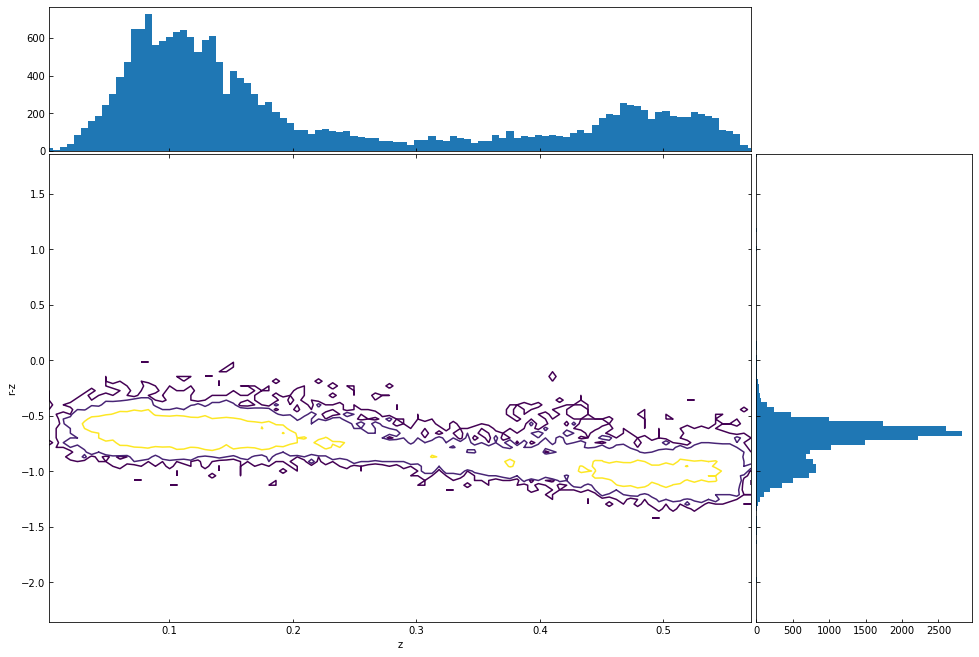

AGN BROADLINE
[0.00036509674939184077, 0.0003650967499682848, 0.0007301935011519763]


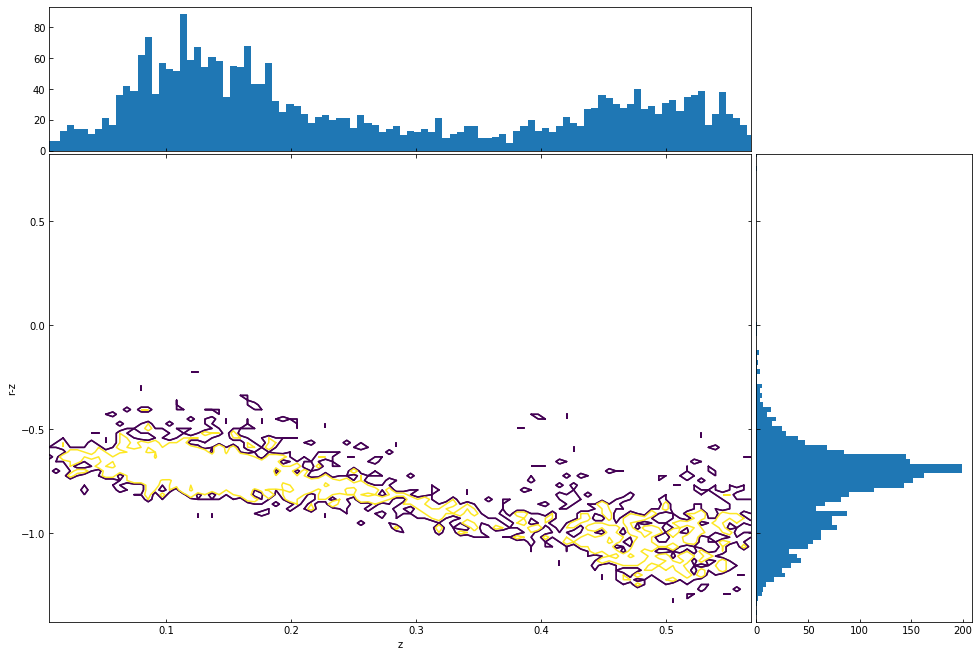

BROADLINE
[0.0001895734607260651, 0.0011374407583552091, 0.0096682464459679]


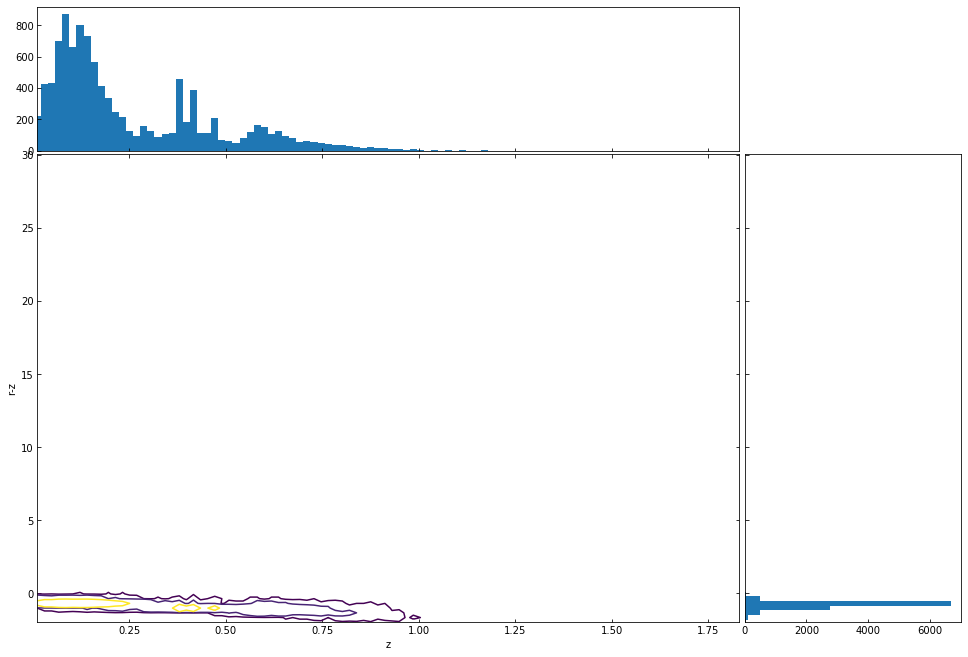

STARBURST
[0.0001223075341587036, 0.0004484609629974099, 0.0038730719574750112]


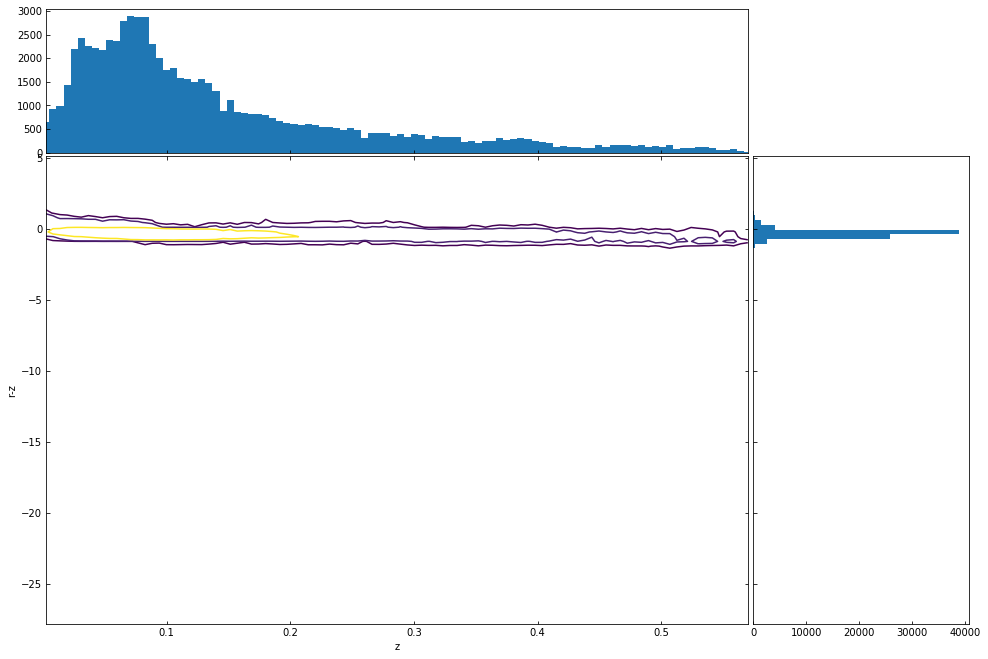

STARBURST BROADLINE
[0.00588235293965675, 0.005882352940824259, 0.005882352940333612]


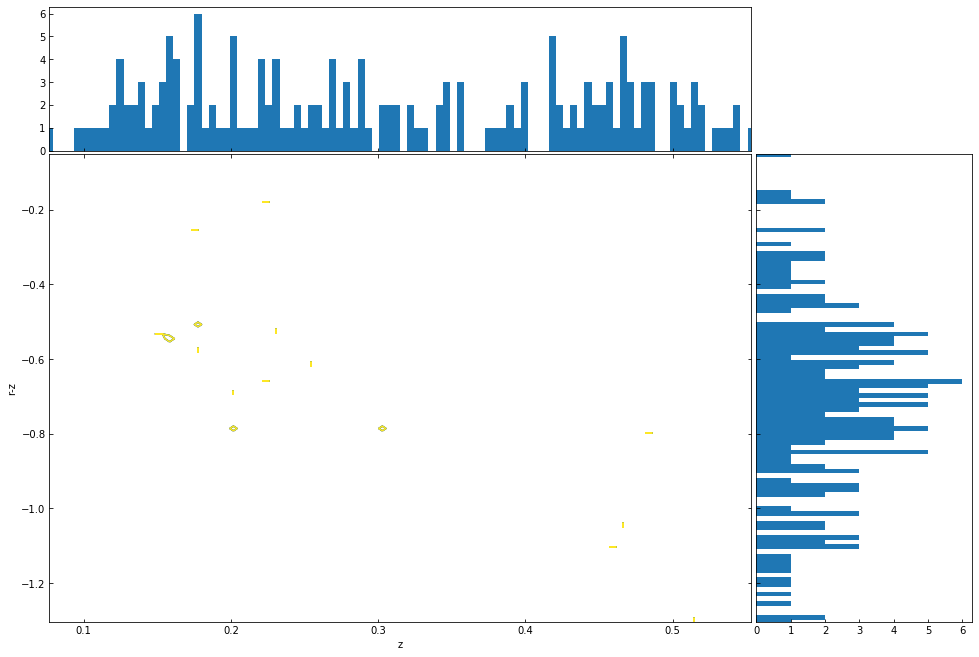

STARFORMING
[5.860977544970013e-05, 0.00035584506947186064, 0.0060368069399833225]


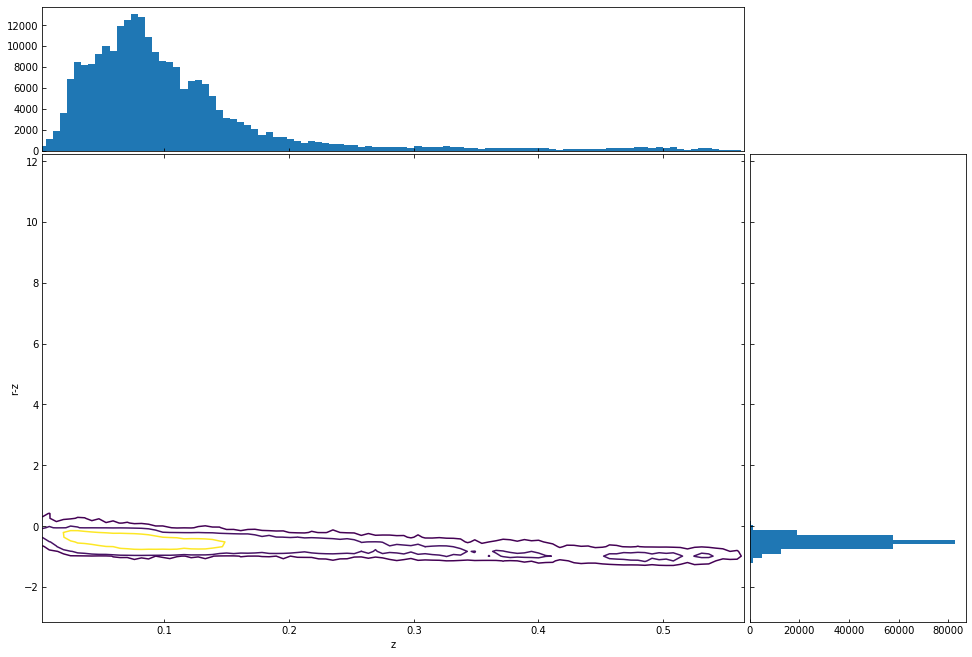

STARFORMING BROADLINE
[0.00093720712152829, 0.0009372071226745939, 0.0009372071235926626]


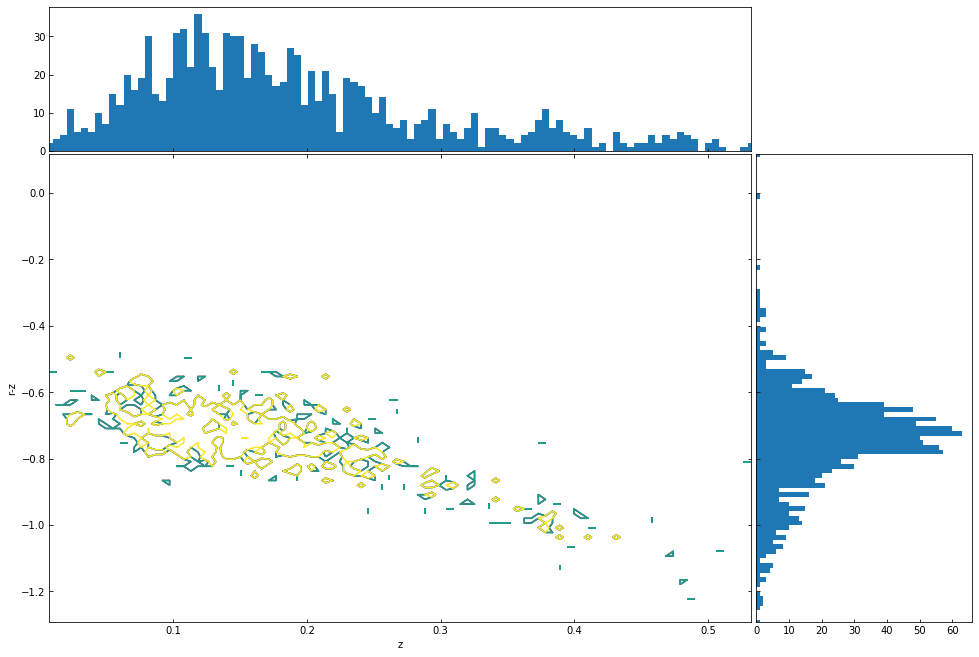

In [131]:
# %% Make r-z vs redshift 2D density contour plot for each galaxy subclass
for j in range(len(subclasses)):
    print(subclasses[j])
    subclass_set = galaxy_nonan[galaxy_nonan['SUBCLASS'] == subclasses[j]]
    rz_colour, z_rz = r_z(subclass_set)
    density_contour_w_hist(z_rz,rz_colour,nbins_x,nbins_y,'z','r-z')

## Colour vs colour

In [137]:
# Define function to find colours g-r and r-z
def combined_colour(table):
    '''
    Returns g-r and r-z colours, with corresponding redshift z values, dropping negative fluxes. This is different to the
    function g_r() and r_z() because if those two were used separately and the resulting columns plotted against each other,
    they would have different column lengths.
    Input arguments:
    table: Astropy table, must have columns labelled 'FLUX_G', 'FLUX_R' and 'FLUX_Z'
    '''
    table_r = table[table['FLUX_R'] > 0.0]
    table_gr = table_r[table_r['FLUX_G'] > 0.0]
    table_grz = table_gr[table_gr['FLUX_Z'] > 0.0]
    gr = -2.5*np.log10(table_grz['FLUX_R']/table_grz['FLUX_G'])
    rz = -2.5*np.log10(table_grz['FLUX_Z']/table_grz['FLUX_R'])
    return gr, rz, table_grz['Z']

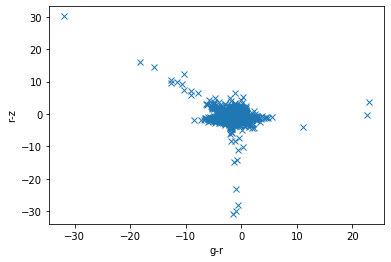

In [141]:
# Plot scatter plot of r-z against g-r
gr, rz, z = combined_colour(galaxy_nonan)
plt.figure()
plt.plot(gr, rz, 'x')
plt.xlabel('g-r')
plt.ylabel('r-z')
plt.show()

[0.005801322167983073, 0.03264116334337789, 0.14564075209472702]


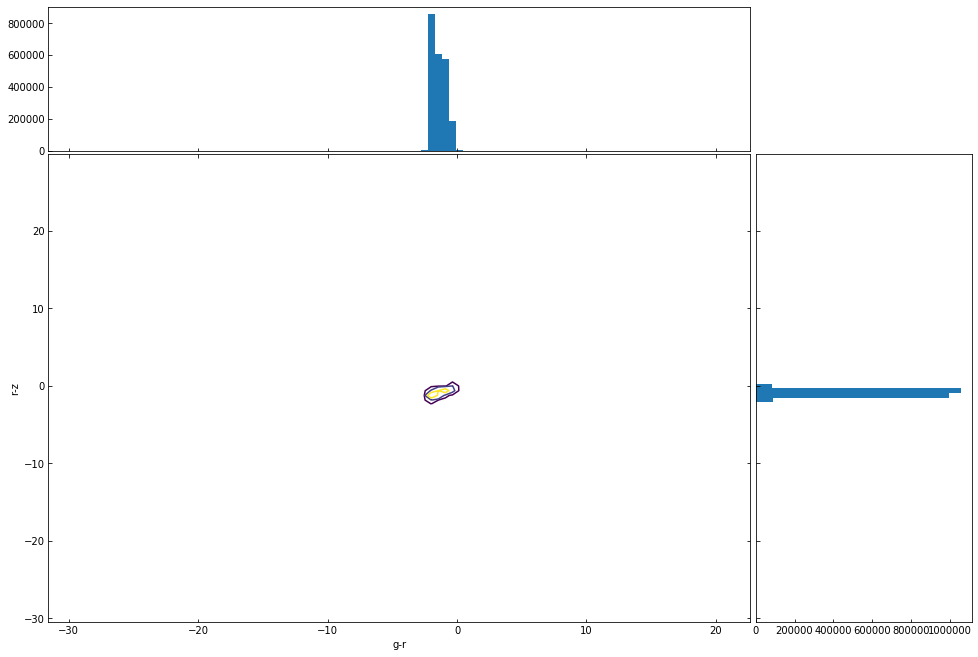

In [142]:
# Plot 2D density contour plot of r-z against g-r
density_contour_w_hist(gr,rz,nbins_x,nbins_y,'g-r','r-z')

 
[0.002496816743955486, 0.02589983919482477, 0.09958400511761452]


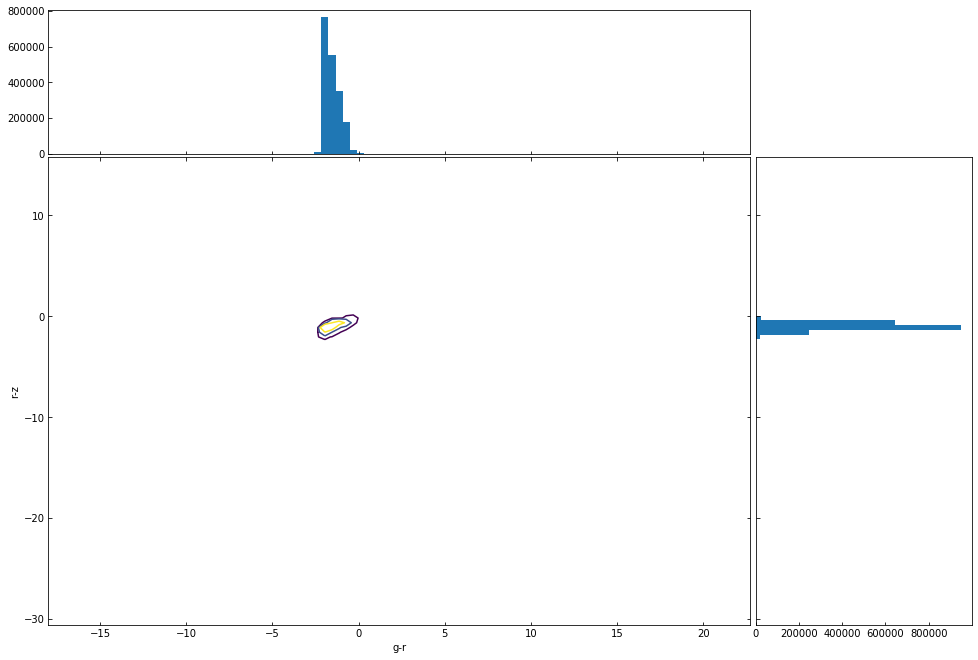

AGN
[5.063803992864593e-05, 0.0003544662762072833, 0.0026838160814181542]


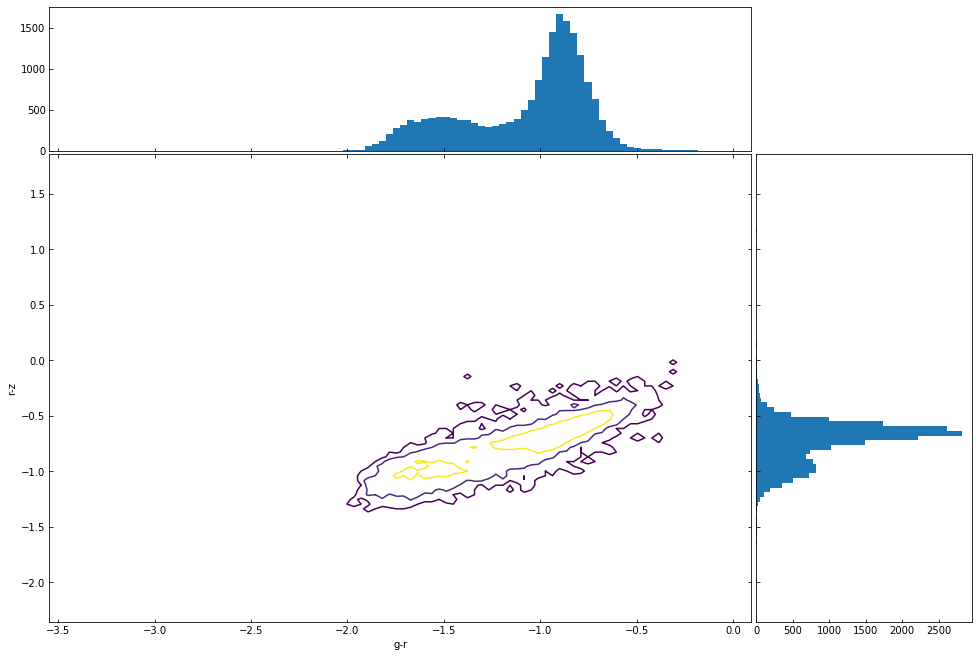

AGN BROADLINE
[0.00036536353576038235, 0.0003653635366102062, 0.0014614541453631927]


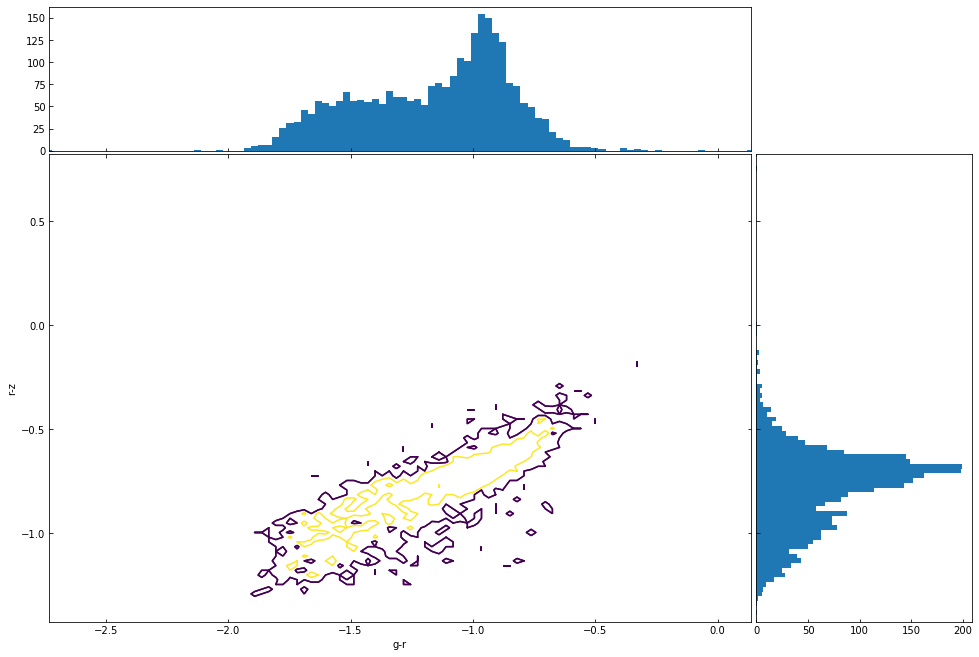

BROADLINE
[0.0013271400136186517, 0.00910038866274894, 0.13764337851850605]


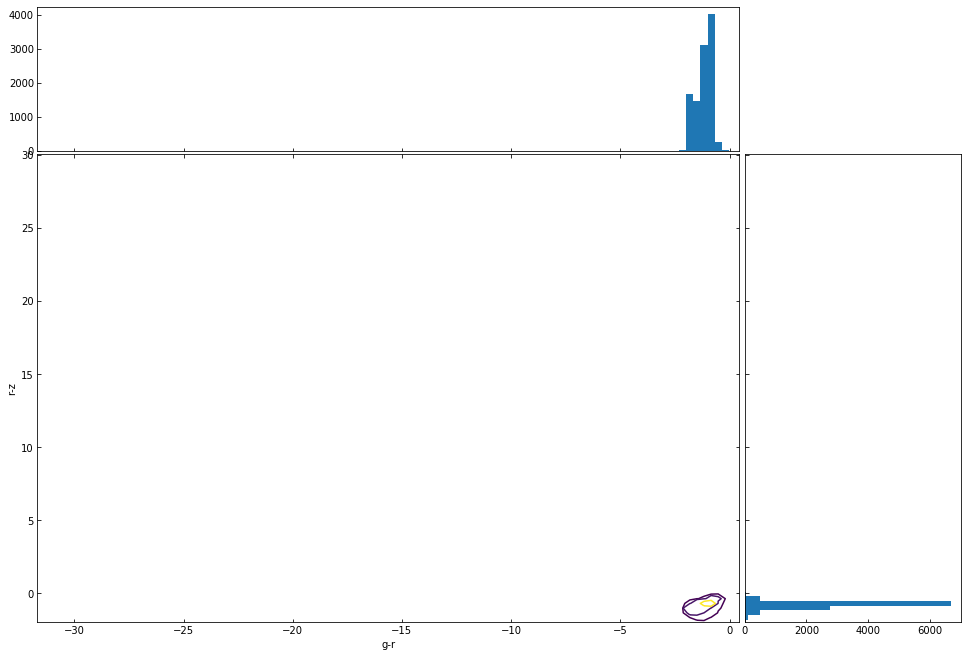

STARBURST
[0.0002718536327937049, 0.001916568121081368, 0.04001685492536179]


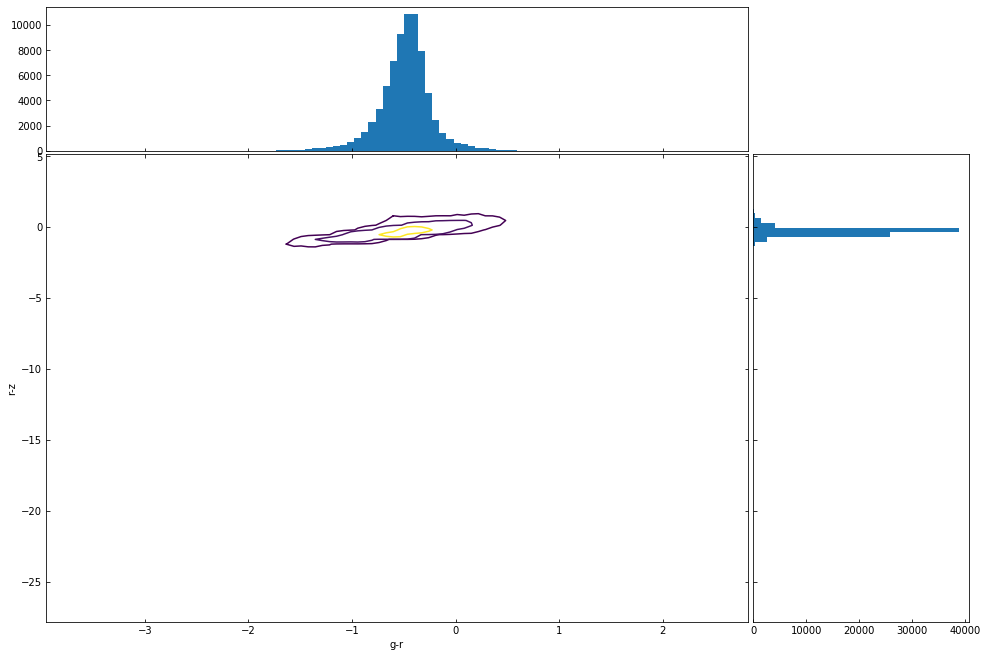

STARBURST BROADLINE
[0.005882352940761891, 0.00588235294085892, 0.00588235294051897]


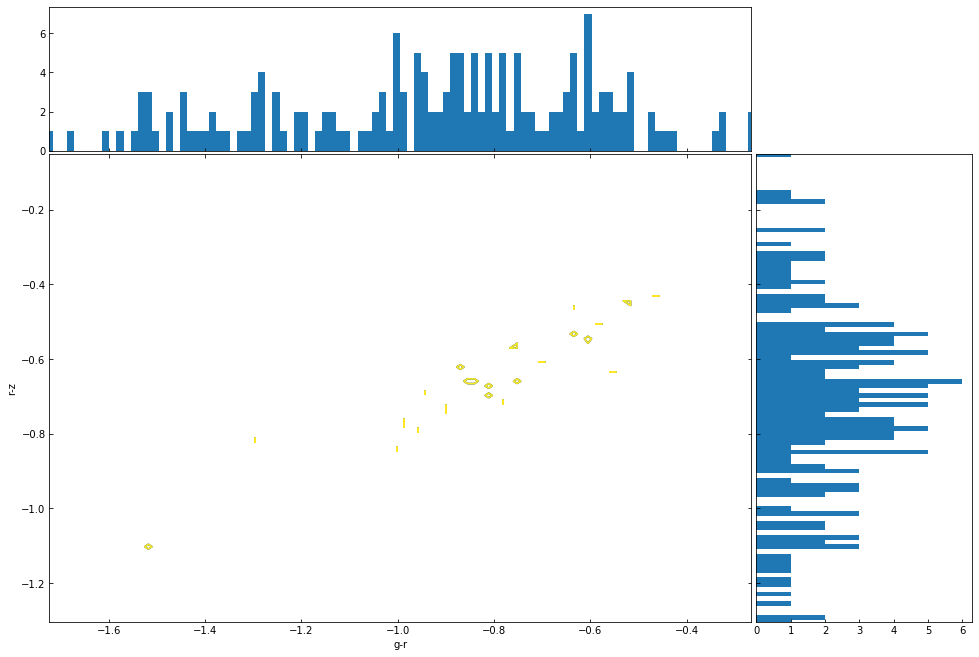

STARFORMING
[0.0006699634442289795, 0.011502434898082725, 0.21112223064309735]


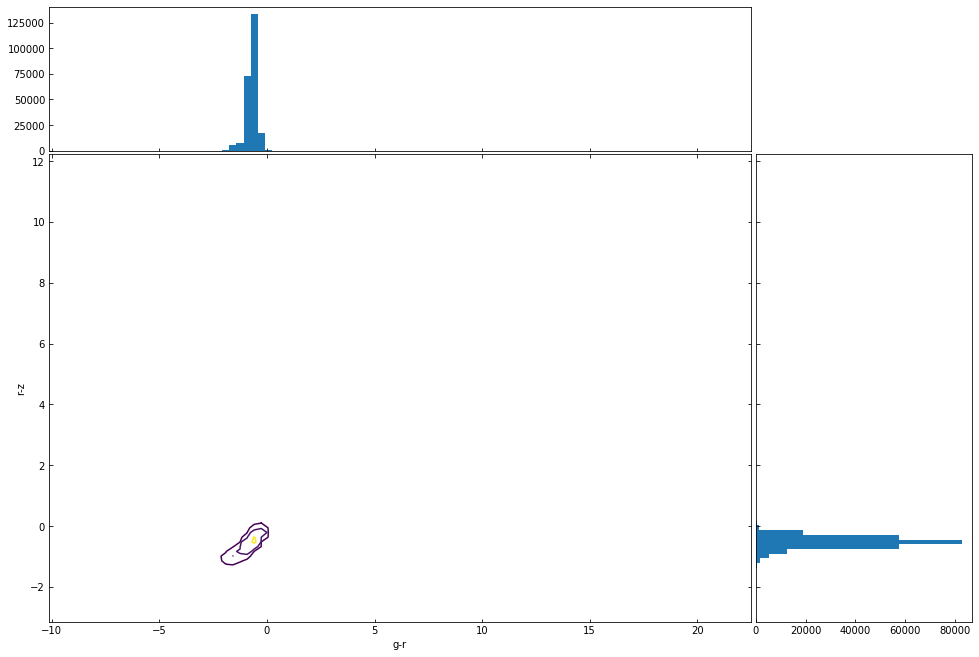

STARFORMING BROADLINE
[0.000937207122605793, 0.0009372071226337395, 0.0009372071229813293]


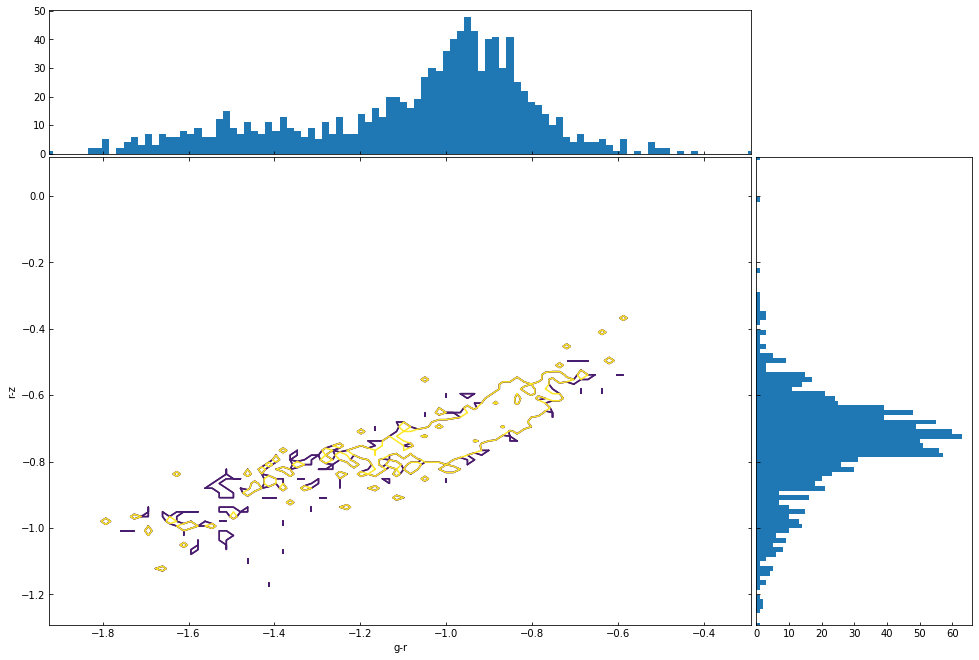

In [143]:
# Plot 2D density contour plot of r-z against g-r for each galaxy subclass
for j in range(len(subclasses)):
    print(subclasses[j])
    subclass_set = galaxy_nonan[galaxy_nonan['SUBCLASS'] == subclasses[j]]
    gr, rz, z = combined_colour(subclass_set)
    density_contour_w_hist(gr,rz,nbins_x,nbins_y,'g-r','r-z')